In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as fit

In [15]:
def exponent(x, a, b):
    return np.exp((x - a) / b)
def linear(x, a, b):
    return a * x + b
def quadratic(x, a, b):
    return (x - a) ** 2 + b

## Data collection zone

In [16]:
import pyvisa as visa
import time

In [17]:
# Temperature sensor config (Pt sensor)
alpha = 4
R_0 = 1000
T_0 = 273

In [18]:
# Getting devices addresses

rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR', 'ASRL2::INSTR')

In [19]:
temp_inst = rm.open_resource('USB0::0x2A8D::0xB318::MY58330049::INSTR', write_termination= '\n', read_termination='\n')

# Setting temperature device in case of Pt sensor
temp_inst.write('CONF:RES')
time.sleep(1)
temp_inst.write('*OPC?')
time.sleep(1)
temp_inst.read()

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [7]:
def get_R(device):
    device.write('INIT')
    device.write('FETC?')
    time.sleep(0.1)
    return float(device.read())

In [8]:
# Get current temperature
temp_R = get_R(temp_inst)
T = (temp_R - R_0) / alpha + T_0
T - 273

-195.640467

## Data analysis zone

In [95]:
filename = 'scope_6.csv'
# scope_0 28
# scope_1 -45
# scope_2 -84.5
# scope_3 -137
# scope_4 -166

# scope_5 20
# scope_6 -68
# scope_7 -130
# scope_8 -170
# scope_9 -195

In [96]:
df = pd.read_csv(filename, header=1)

# Needed for scope_0-4
#df['Volt.1'] = -df['Volt.1']
#df['Volt'] = -df['Volt']
df.dropna(inplace=True)
df.head()

,second,Volt,Volt.1
1,-0.04935,-0.012585,-0.030072
2,-0.04930,-0.081128,-0.030072
3,-0.04925,-0.162233,-0.030072
4,-0.04920,-0.251881,-0.030072
5,-0.04915,-0.339017,-0.030072


In [97]:
x_full = (df['Volt'] - df['Volt.1'])[df['Volt'] - df['Volt.1'] > -0.1]
y_full = (df['Volt.1'] / 100)[df['Volt'] - df['Volt.1'] > -0.1] * 1000

In [98]:
# Fit zone
a, b = fit(exponent, x_full, y_full)[0]

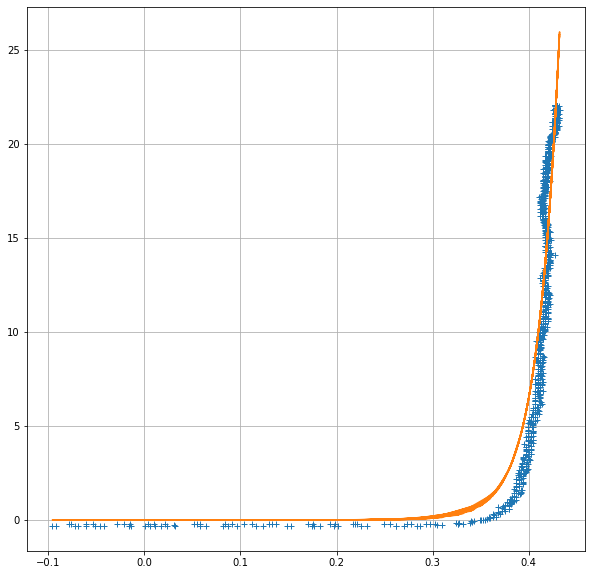

In [99]:
plt.figure(figsize=(10, 10))
plt.plot(x_full, y_full, '+')
plt.plot(x_full, np.exp((x_full - a) / b))
plt.grid()
plt.show()

In [9]:
#temp_dict = {0:28, 1:-45, 2:-84.5, 3:-137, 4:-166}
temp_dict = {5:20, 6:-68, 7:-130, 8:-170, 9:-195}

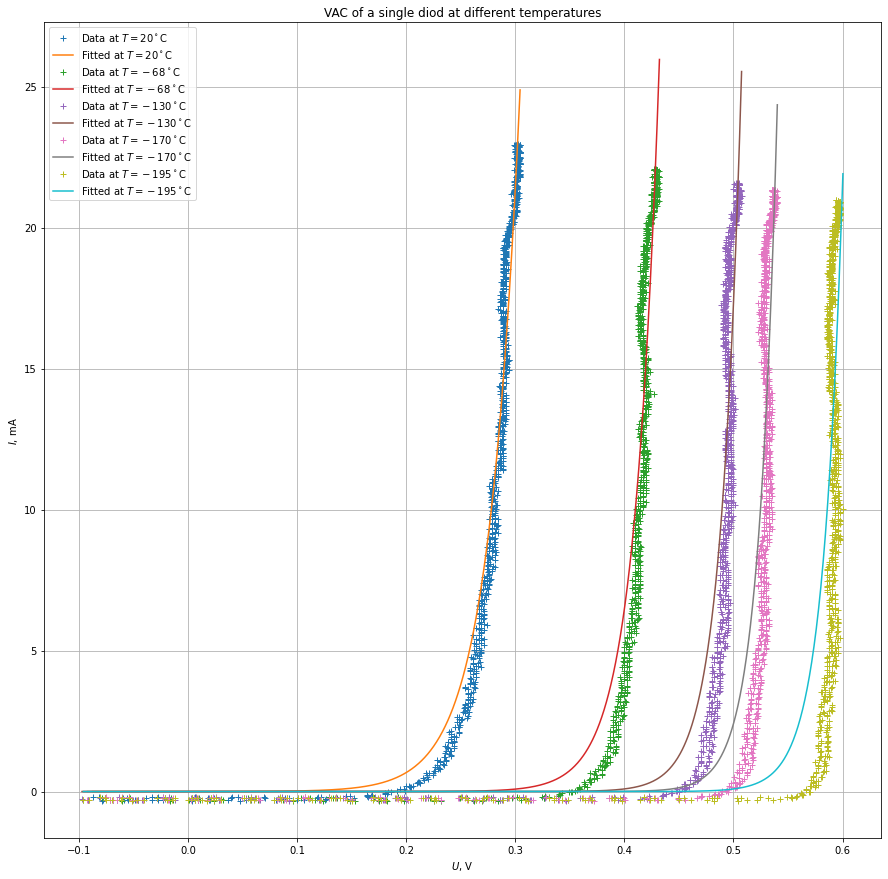

In [20]:
plt.figure(figsize=(15, 15))
for i in range(5, 10):
    filename = 'scope_{}.csv'.format(i)
    df = pd.read_csv(filename, header=1)
    df['Volt.1'] = df['Volt.1']
    df['Volt'] = df['Volt']
    df.dropna(inplace=True)
    x_full = (df['Volt'] - df['Volt.1'])[df['Volt'] - df['Volt.1'] > -0.1]
    y_full = (df['Volt.1'] / 100)[df['Volt'] - df['Volt.1'] > -0.1] * 1000
    x = np.linspace(x_full.min(), x_full.max(), int(1e3))
    plt.plot(x_full, y_full, '+', label='Data at $T = {}^\circ$C'.format(temp_dict[i]))
    a, b = fit(exponent, x_full, y_full)[0]
    plt.plot(x, np.exp((x - a) / b), '-', label='Fitted at $T = {}^\circ$C'.format(temp_dict[i]))
plt.grid()
plt.legend()
plt.xlabel('$U$, V')
plt.ylabel('$I$, mA')
plt.title('VAC of a single diod at different temperatures')
plt.savefig('Diode.pdf')
plt.show()

# Не трогай сожрет
## (Попытки подогнать чем-то лучше, чем просто экспонента)

In [9]:
df = pd.read_csv('scope_0.csv', header=1)
df['Volt.1'] = -df['Volt.1']
df['Volt'] = -df['Volt']
df.head()

,second,Volt,Volt.1
0,-0.05000,4.099395,1.276280
1,-0.04995,4.101707,1.277335
2,-0.04990,4.122411,1.296380
3,-0.04985,4.143968,1.313918
4,-0.04980,4.148792,1.318943


In [97]:
def exponent(x, b, c):
    return np.exp((x - b) / c)
def linear(x, a, b):
    return a * x + b
def quadratic(x, a, b):
    return (x - a) ** 3 + b

In [98]:
x = (df[df['Volt.1'] / 100 > 0.004]['Volt'] - df[df['Volt.1'] / 100 > 0.004]['Volt.1'])
y = (df[df['Volt.1'] / 100 > 0.004]['Volt.1'] / 100)
x1 = df['Volt'] - df['Volt.1']
y1 = df['Volt.1'] / 100
x2 = (df[(df['Volt.1'] / 100 < 0.004) & (df['Volt.1'] / 100 > 0.0005)]['Volt'] - df[(df['Volt.1'] / 100 < 0.004) & (df['Volt.1'] / 100 > 0.0005)]['Volt.1'])
y2 = (df[(df['Volt.1'] / 100 < 0.004) & (df['Volt.1'] / 100 > 0.0005)]['Volt.1'] / 100)
y2.min()

0.0005200862

In [99]:
b, c = fit(exponent, x, y)[0]
d, e = fit(linear, x, y)[0]
f, g = fit(quadratic, x2, y2)[0]

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(x1, y1, '+')
plt.plot(x1, np.exp((x1 - b) / c), label='exp')
plt.plot(x2, (x2 - f) ** 3 + g, label='cube')
#plt.plot(x1, d * x1 + e)

plt.grid()
plt.legend()
plt.show()

NameError: name 'x1' is not defined

In [8]:
rm = visa.ResourceManager()
rm.list_resources()

('USB0::0x2A8D::0x1797::CN58056431::INSTR', 'ASRL1::INSTR', 'ASRL2::INSTR')

In [9]:
oscil = rm.open_resource('USB0::0x2A8D::0x1797::CN58056431::INSTR', write_termination= '\n', read_termination='\n')

In [48]:
oscil.write(':SAVE:FIL "3"')
oscil.query(':SAVE:FIL?')

'"3"'

In [49]:
oscil.write(':SAVE:WAVeform:FORMat CSV')
oscil.query(':SAVE:WAVeform:FORMat?')

'CSV'

In [62]:
oscil.write(':SAVE:PWD "/Users/fess/Music/Temp"')

35

In [53]:
oscil.write(':SAVE:WAV')

10